## **1: Import packages and Load data**

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import os

In [28]:
print(os.listdir("../Dự đoán doanh số bán hàng/"))

['annualSales2019.csv', 'MLP.ipynb', 'venv']


In [29]:
df = pd.read_csv("../Dự đoán doanh số bán hàng/annualSales2019.csv")

## **2: Clean and Preprocess data**

In [30]:
df['Month'] = df['Order Date'].str[0:2]
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month
0,141234,iPhone,1,700,01/22/19 21:25,"944 Walnut St, Boston, MA 02215",01
1,141235,Lightning Charging Cable,1,14.95,01/28/19 14:15,"185 Maple St, Portland, OR 97035",01
2,141236,Wired Headphones,2,11.99,01/17/19 13:33,"538 Adams St, San Francisco, CA 94016",01
3,141237,27in FHD Monitor,1,149.99,01/05/19 20:33,"738 10th St, Los Angeles, CA 90001",01
4,141238,Wired Headphones,1,11.99,01/25/19 11:59,"387 10th St, Austin, TX 73301",01


In [31]:
# set: lấy ra unique element
print(set(df['Month']))

{'01', '12', '06', '10', 'Or', '03', '04', '07', '09', nan, '05', '08', '11', '02'}


In [32]:
df = df.dropna(how='all')
df = df[df['Month'] != 'Or']
print(set(df['Month']))

{'01', '12', '06', '10', '03', '04', '07', '09', '05', '08', '11', '02'}


In [33]:
# Chuyển đổi 'Order Date' thành kiểu datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')

# Trích xuất thông tin thời gian
df['Hour'] = df['Order Date'].dt.hour
df['Day of Week'] = df['Order Date'].dt.dayofweek

# Hiển thị kết quả
df[['Order Date', 'Hour', 'Day of Week']].head()

C:\Users\inhta\AppData\Local\Temp\ipykernel_3096\2490409568.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')


,Order Date,Hour,Day of Week
0,2019-01-22 21:25:00,21,1
1,2019-01-28 14:15:00,14,0
2,2019-01-17 13:33:00,13,3
3,2019-01-05 20:33:00,20,5
4,2019-01-25 11:59:00,11,4


In [34]:
# Trích xuất thành phố từ 'Purchase Address'
df['City'] = df['Purchase Address'].apply(lambda x: x.split(',')[1].strip())

# Hiển thị kết quả
df[['Purchase Address', 'City']].head()

,Purchase Address,City
0,"944 Walnut St, Boston, MA 02215",Boston
1,"185 Maple St, Portland, OR 97035",Portland
2,"538 Adams St, San Francisco, CA 94016",San Francisco
3,"738 10th St, Los Angeles, CA 90001",Los Angeles
4,"387 10th St, Austin, TX 73301",Austin


In [35]:
# Chuyển đổi kiểu dữ liệu
df['Quantity Ordered'] = pd.to_numeric(df['Quantity Ordered'], errors='coerce')
df['Price Each'] = pd.to_numeric(df['Price Each'], errors='coerce')

In [36]:
print(df['Quantity Ordered'].dtype)
print(df['Price Each'].dtype)

int64
float64


In [37]:
# Tính tổng doanh số
df['Total Sales'] = df['Quantity Ordered'] * df['Price Each']

# Hiển thị kết quả
df[['Quantity Ordered', 'Price Each', 'Total Sales']].head()

,Quantity Ordered,Price Each,Total Sales
0,1,700.00,700.00
1,1,14.95,14.95
2,2,11.99,23.98
3,1,149.99,149.99
4,1,11.99,11.99


In [38]:
from sklearn.preprocessing import LabelEncoder

# Mã hóa cột 'Product' bằng Label Encoding
product_encoder = LabelEncoder()
df['Product Encoded'] = product_encoder.fit_transform(df['Product'])

# Mã hóa cột 'City' bằng Label Encoding
city_encoder = LabelEncoder()
df['City Encoded'] = city_encoder.fit_transform(df['City'])

# Hiển thị kết quả
df[['Product', 'Product Encoded', 'City', 'City Encoded']].head()

,Product,Product Encoded,City,City Encoded
0,iPhone,18,Boston,2
1,Lightning Charging Cable,12,Portland,6
2,Wired Headphones,17,San Francisco,7
3,27in FHD Monitor,2,Los Angeles,4
4,Wired Headphones,17,Austin,1


In [39]:
from sklearn.preprocessing import StandardScaler

# Chọn các cột số để chuẩn hóa
num_features = ['Quantity Ordered', 'Price Each', 'Hour', 'Day of Week', 'Total Sales']
scaler = StandardScaler()

# Chuẩn hóa dữ liệu
df[num_features] = scaler.fit_transform(df[num_features])

# Hiển thị kết quả
df[num_features].head()

,Quantity Ordered,Price Each,Hour,Day of Week,Total Sales
0,-0.280906,1.549604,1.214495,-0.994765,1.545449
1,-0.280906,-0.509270,-0.076208,-1.494274,-0.512260
2,1.977493,-0.518166,-0.260594,0.004255,-0.485136
3,-0.280906,-0.103416,1.030109,1.003275,-0.106635
4,-0.280906,-0.518166,-0.629366,0.503765,-0.521151


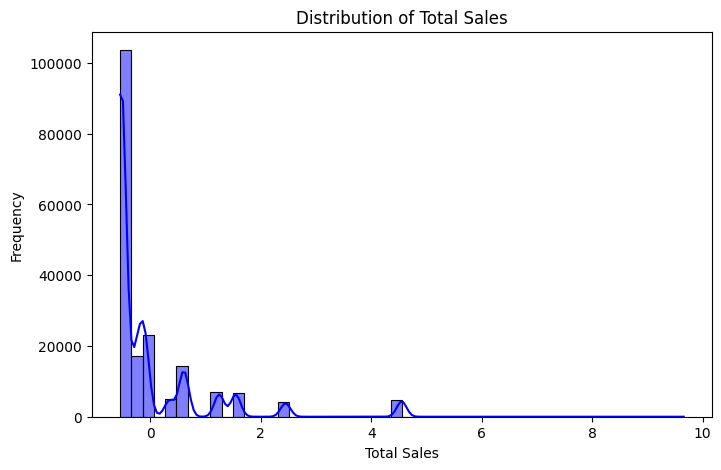

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Vẽ biểu đồ phân bố của biến mục tiêu (Total Sales)
plt.figure(figsize=(8, 5))
sns.histplot(df['Total Sales'], bins=50, kde=True, color='blue')
plt.xlabel("Total Sales")
plt.ylabel("Frequency")
plt.title("Distribution of Total Sales")
plt.show()

- Dữ liệu khá lệch về phía 0, cho thấy có nhiều giao dịch có tổng doanh số thấp.

- Có một số giá trị cao hơn, có thể là các sản phẩm có giá trị lớn hoặc mua với số lượng nhiều.

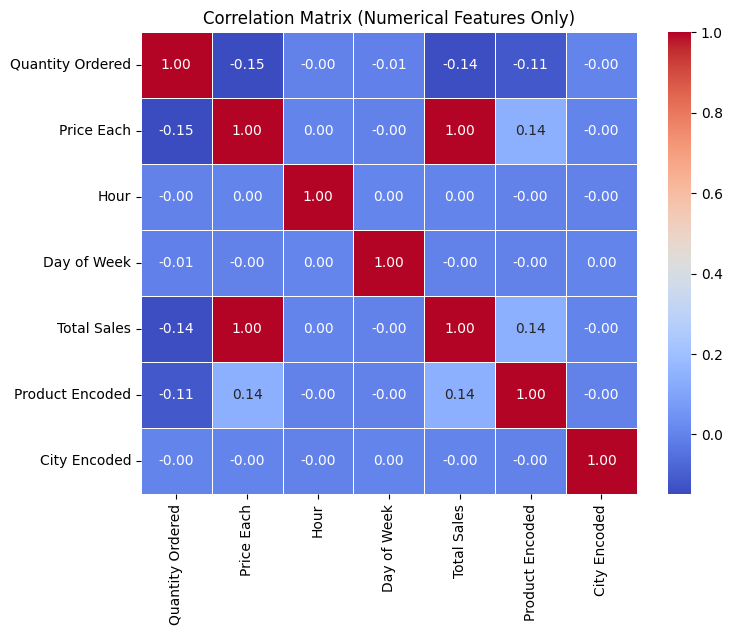

In [41]:
# Lọc các cột số để vẽ ma trận tương quan
num_features = ['Quantity Ordered', 'Price Each', 'Hour', 'Day of Week', 
                'Total Sales', 'Product Encoded', 'City Encoded']

# Vẽ lại ma trận tương quan chỉ với các cột số
plt.figure(figsize=(8, 6))
correlation_matrix = df[num_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Numerical Features Only)")
plt.show()

- Total Sales có tương quan mạnh nhất với Price Each (1.00), do công thức tính doanh số là Quantity Ordered * Price Each.

- Product Encoded có tương quan nhẹ (0.14) với Total Sales, nghĩa là một số sản phẩm có doanh thu cao hơn sản phẩm khác.

- Quantity Ordered và Price Each có tương quan âm (-0.15), có thể do sản phẩm đắt tiền ít khi được mua số lượng lớn.

In [42]:
df.head(1)

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,Hour,Day of Week,City,Total Sales,Product Encoded,City Encoded
0,141234,iPhone,-0.280906,1.549604,2019-01-22 21:25:00,"944 Walnut St, Boston, MA 02215",01,1.214495,-0.994765,Boston,1.545449,18,2


In [43]:
# Chọn các cột đặc trưng và cột mục tiêu
selected_features = ['Quantity Ordered', 'Price Each', 'Hour', 'Day of Week', 'Product Encoded']
X = df[selected_features]  # Đặc trưng đầu vào
y = df['Total Sales']  # Biến mục tiêu

# Chia tập dữ liệu thành train (80%) và test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Kiểm tra kích thước tập dữ liệu sau khi chia
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(148760, 5) (37190, 5) (148760,) (37190,)


In [46]:
# Khởi tạo bộ chuẩn hóa
scaler = StandardScaler()

# Áp dụng chuẩn hóa lên tập train và test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Kiểm tra lại kích thước sau khi chuẩn hóa
X_train_scaled.shape, X_test_scaled.shape

((148760, 5), (37190, 5))

## **3: Build Model**

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Xây dựng mô hình MLP
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Lớp đầu ra cho bài toán hồi quy
])

# Biên dịch mô hình
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

# Hiển thị cấu trúc mô hình
model.summary()

c:\DEV\python_code\Project\Neural Networks & Unsupervised\Dự đoán doanh số bán hàng\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,137 (43.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Thiết lập Early Stopping để tránh overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# Huấn luyện mô hình
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.4551 - mae: 0.4286 - val_loss: 0.0103 - val_mae: 0.0612
Epoch 2/100
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.1196 - mae: 0.2273 - val_loss: 0.0201 - val_mae: 0.0516
Epoch 3/100
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0925 - mae: 0.2089 - val_loss: 0.0352 - val_mae: 0.0860
Epoch 4/100
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.0792 - mae: 0.1933 - val_loss: 0.0255 - val_mae: 0.1196
Epoch 5/100
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0748 - mae: 0.1918 - val_loss: 0.0210 - val_mae: 0.1134
Epoch 6/100
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0743 - mae: 0.1926 - val_loss: 0.0318 - val_mae: 0.1536
Epoch 7/100
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0749 - mae: 0.1931 - val_loss: 0.0232 - val_mae: 0.1302
Epoch 8/100
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0696 - mae: 0.1868 - val_loss: 0.0205 - val_mae: 0.1193
Epoch 9/100
3719/3719 ━━━━━━━━━━

In [ ]:
# Đánh giá trên tập test
test_loss, test_mae = model.evaluate(X_test_scaled, y_test)
print(f"Test loss (MSE): {test_loss:.4f}")
print(f"Test Mean Absolute Error: {test_mae:.4f}")

# Dự đoán trên tập test
y_pred = model.predict(X_test_scaled).flatten()

# Tính các chỉ số đánh giá chi tiết
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 1s 824us/step - loss: 0.0099 - mae: 0.0605
Test loss (MSE): 0.0110
Test Mean Absolute Error: 0.0615
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 1s 520us/step
Mean Squared Error: 0.0110
Root Mean Squared Error: 0.1048
Mean Absolute Error: 0.0615
R² Score: 0.9894


In [49]:
# Lưu mô hình để sử dụng sau này
model.save('sales_prediction_model.h5')
print("Đã lưu mô hình vào file 'sales_prediction_model.h5'")

Đã lưu mô hình vào file 'sales_prediction_model.h5'


In [ ]:
model = load_model('sales_prediction_model.h5')

# Tạo dữ liệu mẫu để dự đoán
# Giả sử: Khách hàng mua 2 iPhone giá 700$ vào 18h thứ 5
new_order = {
    'Quantity Ordered': 2,
    'Price Each': 700,
    'Hour': 18,
    'Day of Week': 4,
    'Product Encoded': 18
}

# Tạo một StandardScaler mới và fit trên tập dữ liệu X_train
new_scaler = StandardScaler()
new_scaler.fit(X_train)  # X_train là dữ liệu đã dùng để huấn luyện trước đó

# Chuyển đổi dữ liệu mới thành định dạng cần thiết
new_data = np.array([[
    new_order['Quantity Ordered'],
    new_order['Price Each'],
    new_order['Hour'],
    new_order['Day of Week'],
    new_order['Product Encoded']
]])

# Chuẩn hóa dữ liệu mới với scaler mới
new_data_scaled = new_scaler.transform(new_data)

# Dự đoán
predicted_sales = model.predict(new_data_scaled)
print(f"Doanh số dự đoán: {predicted_sales[0][0]:.2f}")
print(f"Doanh số thực tế: {new_order['Quantity Ordered'] * new_order['Price Each']:.2f}$")

# In ra độ chênh lệch
difference = abs(predicted_sales[0][0] - (new_order['Quantity Ordered'] * new_order['Price Each']))
print(f"Chênh lệch: {difference:.2f}$")
print(f"Độ chính xác: {(1 - difference/(new_order['Quantity Ordered'] * new_order['Price Each'])) * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step

c:\DEV\python_code\Project\Neural Networks & Unsupervised\Dự đoán doanh số bán hàng\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Doanh số dự đoán: -15.97
Doanh số thực tế: 1400.00$
Chênh lệch: 1415.97$
Độ chính xác: -1.14%
